In [1]:
import sys, importlib
print("Python:", sys.executable)  # debería verse .../envs/tathu_env/bin/python

for m in ["cartopy","netCDF4","rtree"]:
    try:
        importlib.import_module(m)
        print(f"{m}: OK")
    except Exception as e:
        print(f"{m}: ERROR -> {e}")

Python: /home/thomas/miniconda3/bin/python
cartopy: OK
netCDF4: OK
rtree: ERROR -> No module named 'rtree'


In [2]:
%pip install --quiet geopandas
%pip install --quiet --no-deps "git+https://github.com/uba/tathu.git"
%pip install -q scikit-image scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install arm-pyart==1.19.0 xarray-datatree==0.0.14 xarray==2024.9.0

In [4]:
import pyart
import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
#####################################################################################################
dato_radar_inicial="datos/RMA1_0303_01_20241128T200036Z.nc"
dato_radar_current_1="datos/RMA1_0303_01_20241128T201336Z.nc"
dato_radar_current_2="datos/RMA1_0303_01_20241128T202635Z.nc"
dato_radar_current_3="datos/RMA1_0303_01_20241128T203936Z.nc"
dato_radar_current_4="datos/RMA1_0303_01_20241128T205235Z.nc"

#####################################################################################################
dato_radar_inicial = pyart.io.read(dato_radar_inicial)
dato_radar_current_1 = pyart.io.read(dato_radar_current_1)
dato_radar_current_2 = pyart.io.read(dato_radar_current_2)
dato_radar_current_3 = pyart.io.read(dato_radar_current_3)
dato_radar_current_4 = pyart.io.read(dato_radar_current_4)

#####################################################################################################

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyart
import numpy as np
from datetime import datetime, timedelta
import copy

#------------------------ Función más básica ---------------
#------------------------ Para graficar mapa PPI -----------

def graficar_ppi_map(elevacion, radar, variable, lat_objetivo=None, lon_objetivo=None):
    # Configuración de visualización
    vmin, vmax, cmap = obtener_configuracion_visualizacion(variable, radar)

    # Crear figura
    fig = plt.figure(figsize=(10, 8))
    projection = ccrs.Mercator()
    ax = plt.subplot(1, 1, 1, projection=projection)

    # Mostrar el PPI
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(
        variable,
        elevacion,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        projection=projection,
        ax=ax,
        lat_lines=np.arange(-30, -40, -1),  # Líneas de latitud cada 1°
        lon_lines=np.arange(-60, -70, -1)   # Líneas de longitud cada 1°
    )

    # Marcar ubicación del radar
    display.plot_point(
        radar.longitude['data'][0],
        radar.latitude['data'][0],
        'r*',
        label=radar.metadata['instrument_name'],
        markersize=15,
        transform=ccrs.PlateCarree()
    )

    # # Marcar punto objetivo si se especificó
    # if lat_objetivo is not None and lon_objetivo is not None:
    #     ax.plot(
    #         lon_objetivo,
    #         lat_objetivo,
    #         'bo',
    #         markersize=8,
    #         label='Punto Objetivo',
    #         transform=ccrs.PlateCarree()
    #     )
    #     # Línea desde el radar al objetivo
    #     ax.plot(
    #         [radar.longitude['data'][0], lon_objetivo],
    #         [radar.latitude['data'][0], lat_objetivo],
    #         'k--',
    #         linewidth=1.5,
    #         label='Línea al objetivo',
    #         transform=ccrs.PlateCarree()
    #     )

    # Añadir anillo de 240 km
    display.plot_range_rings([240], ax=ax, lw=1, col='red', ls='-')

    # Configuración adicional
    ax.set_title(
        f"{radar.metadata['instrument_name']} - {obtener_fecha_radar(radar)}\n"
        f"{variable} - Elevación: {elevacion}",
        fontsize=12
    )
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def obtener_configuracion_visualizacion(variable, radar):
    config = {
        'WRAD': {'vmin': -30, 'vmax': 30, 'cmap': 'pyart_NWSVel'},
        'KDP': {'vmin': -2, 'vmax': 5, 'cmap': 'pyart_Theodore16'},
        'DBZV': {'vmin': -10, 'vmax': 60, 'cmap': 'pyart_NWSRef'},
        'DBZH': {'vmin': -10, 'vmax': 60, 'cmap': 'pyart_NWSRef'},
        'ZDR': {'vmin': -1, 'vmax': 5, 'cmap': 'pyart_RefDiff'},
        'VRAD': {'vmin': -30, 'vmax': 30, 'cmap': 'pyart_NWSVel'},
        'RHOHV': {'vmin': 0.5, 'vmax': 1, 'cmap': 'pyart_RefDiff'},
        'PHIDP': {'vmin': -180, 'vmax': 180, 'cmap': 'pyart_Theodore16'}
    }
    if variable in config:
        return config[variable]['vmin'], config[variable]['vmax'], config[variable]['cmap']
    else:
        data = radar.fields[variable]['data']
        return np.nanmin(data), np.nanmax(data), 'viridis'

def obtener_fecha_radar(radar):
    fecha_creacion = radar.metadata["created"]
    try:
        fecha_str, hora_str = fecha_creacion.split("Hora:")
        hora_original = datetime.strptime(hora_str.strip(), "%H:%M:%S")
        hora_modificada = hora_original - timedelta(hours=3)
        return f"{fecha_str}Hora:{hora_modificada.strftime('%H:%M:%S')}"
    except:
        return fecha_creacion

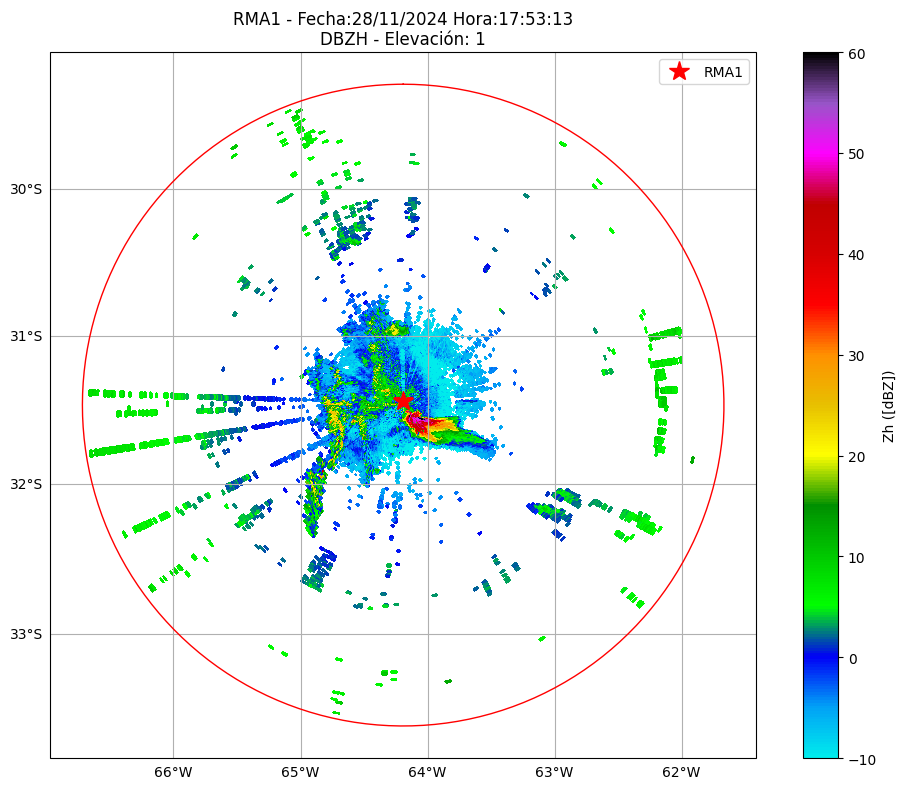

In [7]:
graficar_ppi_map(1, dato_radar_current_4, 'DBZH')

In [9]:
## CREAMOS EL SYSTEMS PARA EL PRIMER DATO DE RADAR
from pyart.map import grid_from_radars
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_inicial = grid_from_radars(
    (dato_radar_inicial,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
### AHORA HACEMOs LO MISMO PARA EL SEGUNDO DATO DE RADAR #################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
grid_current_1 = grid_from_radars(
    (dato_radar_current_1,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################
# Crea grilla: 10 niveles verticales de 0 a 10 km, en 100x100 km horizontal
### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_2 = grid_from_radars(
    (dato_radar_current_2,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])

### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_3 = grid_from_radars(
    (dato_radar_current_3,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])

### PARA EL TERCER DATO DE RADAR QUE USAMOS PARA CORROBORAR ####################
grid_current_4 = grid_from_radars(
    (dato_radar_current_4,),
    grid_shape=(10, 200, 200),  # Z, Y, X → 10 niveles, 200x200 horizontal
    grid_limits=((0, 10000), (-100000, 100000), (-100000, 100000)),  # Z, Y, X en metros
    fields=['DBZH'])
#####################################################################################################

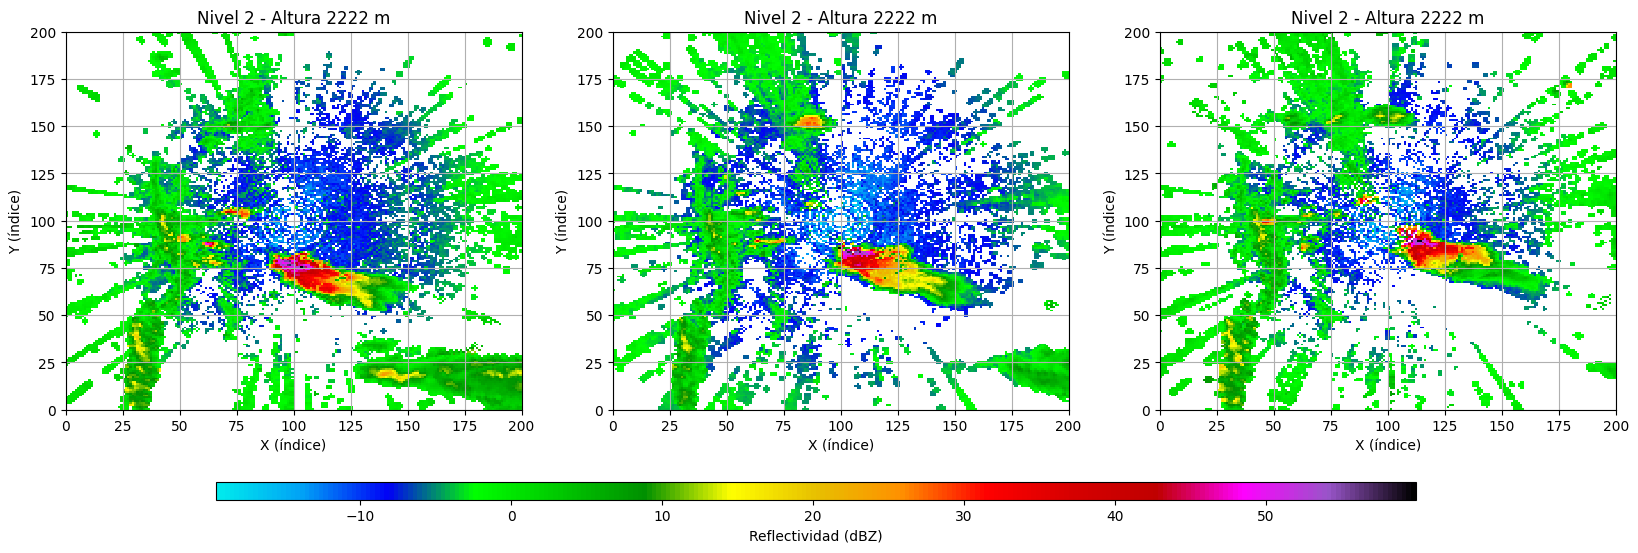

In [10]:
import matplotlib.pyplot as plt

# Lista de grids que querés graficar
grids = [grid_current_2, grid_current_3, grid_current_4]
nivel = 2  # Nivel vertical que vas a graficar

fig, axs = plt.subplots(1,3, figsize=(20, 6))  # 1 fila 4 columnas

for i, grid in enumerate(grids):
    altura_m = grid.z['data'][nivel]
    dbz = grid.fields['DBZH']['data'][nivel]

    im = axs[i].pcolormesh(dbz, cmap='pyart_NWSRef', shading='auto')
    axs[i].set_title(f"Nivel {nivel} - Altura {altura_m:.0f} m")
    axs[i].set_xlabel("X (índice)")
    axs[i].set_ylabel("Y (índice)")
    axs[i].grid(True)

fig.subplots_adjust(bottom=0.25)
# Barra de color horizontal
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Reflectividad (dBZ)')

plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from skimage import measure
import scipy.ndimage as ndi
from matplotlib.colors import ListedColormap

#### esta función te devuelve los SC encontrados y los grafica #################
######### SE UTILIZA DE A UN SISTEMA PARTICULAR ################################

def detectar_sistemas_convectivos(grid, nivel=0, umbral_dbz=35, min_area_km2=100,
                                   extent_km=200, plot=False):
    # 1 Extraer reflectividad
    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    # 2 Umbral binario
    binary = dbz_slice > umbral_dbz
    # 3 Etiquetado
    labeled_array, num_features = ndi.label(binary)
    # 4 Área por sistema
    areas = ndi.sum(binary, labeled_array, index=np.arange(1, num_features+1))
    # 5 Filtro de área (en km²)
    pixel_spacing_km = extent_km / labeled_array.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    valid_labels = [i+1 for i, area in enumerate(areas) if area * pixel_area_km2 >= min_area_km2]
    # 6 Visualización
    if plot:
        cmap = ListedColormap(['white', 'black'])
        plt.figure(figsize=(8, 6))
        plt.imshow(np.isin(labeled_array, valid_labels), cmap=cmap, origin='lower')
        plt.title(f'Sistemas detectados - nivel {nivel} ({grid.z["data"][nivel]:.0f} m)')
        plt.colorbar()
        plt.grid(True)
        plt.show()
    # 7 Extraer contornos principales y atributos
    x_min = -extent_km / 2
    y_min = -extent_km / 2
    systems = []
    for label in valid_labels:
        mask = labeled_array == label
        contours = measure.find_contours(mask, 0.5)
        if not contours:
            continue
        # Solo el contorno más largo
        contour = max(contours, key=len)
        row = contour[:, 0]
        col = contour[:, 1]
        x = x_min + col * pixel_spacing_km
        y = y_min + row * pixel_spacing_km
        poly = Polygon(zip(x, y))
        if not poly.is_valid or poly.area == 0:
            continue
        centroid = poly.centroid
        area_km2 = poly.area
        max_dbz = np.max(dbz_slice[mask])
        mean_dbz = np.mean(dbz_slice[mask])
        systems.append({
            'id': label,
            'geometry': poly,
            'centroid': centroid,
            'area_km2': area_km2,
            'max_dbz': max_dbz,
            'mean_dbz': mean_dbz
        })
    return systems

##### USO ######################################################################
##### GUARDO LOS DICCIONARIOS CON SISTEMAS #####################################
systems_inicial = detectar_sistemas_convectivos(grid_inicial, nivel=1, umbral_dbz=40, min_area_km2=100,
                                   extent_km=200, plot=False)
systems_current_1 = detectar_sistemas_convectivos(grid_current_1, nivel=1, umbral_dbz=40, min_area_km2=100,
                                   extent_km=200, plot=False)
systems_current_2 = detectar_sistemas_convectivos(grid_current_2, nivel=1, umbral_dbz=40, min_area_km2=100,
                                   extent_km=200, plot=False)

In [35]:
#### ESTA FUNCIóN PERMITE GRAFICAR EN UNA MISMA FILA LOS SISTEMAS de DIFERENTES datos ##########################

def detectar_sistemas_convectivos_visual(grid, nivel=0, umbral_dbz=40, min_area_km2=80,
                                   extent_km=200, plot=True, return_axes=False, return_mask=False):

    dbz_slice = grid.fields['DBZH']['data'][nivel, :, :]
    binary = dbz_slice > umbral_dbz
    labeled_array, num_features = ndi.label(binary)
    areas = ndi.sum(binary, labeled_array, index=np.arange(1, num_features+1))

    pixel_spacing_km = extent_km / labeled_array.shape[0]
    pixel_area_km2 = pixel_spacing_km ** 2
    valid_labels = [i+1 for i, area in enumerate(areas) if area * pixel_area_km2 >= min_area_km2]
    mask = np.isin(labeled_array, valid_labels)

    fig, ax = None, None
    if (plot or return_axes) and np.any(mask):
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = ListedColormap(['white', 'black'])
        im = ax.imshow(mask, cmap=cmap, origin='lower')
        ax.set_title(f'Sistemas detectados - nivel {nivel} ({grid.z["data"][nivel]:.0f} m)')
        fig.colorbar(im, ax=ax)
        ax.grid(True)
        if plot:
            plt.show()

    # Extraer contornos y atributos
    x_min = -extent_km / 2
    y_min = -extent_km / 2
    systems = []

    for label in valid_labels:
        region_mask = labeled_array == label
        contours = measure.find_contours(region_mask, 0.5)
        if not contours:
            continue
        contour = max(contours, key=len)
        row = contour[:, 0]
        col = contour[:, 1]
        x = x_min + col * pixel_spacing_km
        y = y_min + row * pixel_spacing_km
        poly = Polygon(zip(x, y))
        if not poly.is_valid or poly.area == 0:
            continue
        systems.append({
            'id': label,
            'geometry': poly,
            'centroid': poly.centroid,
            'area_km2': poly.area,
            'max_dbz': np.max(dbz_slice[region_mask]),
            'mean_dbz': np.mean(dbz_slice[region_mask])
        })

    # retorno
    if return_axes:
        return systems, fig, ax
    elif return_mask:
        return systems, mask
    else:
        return systems


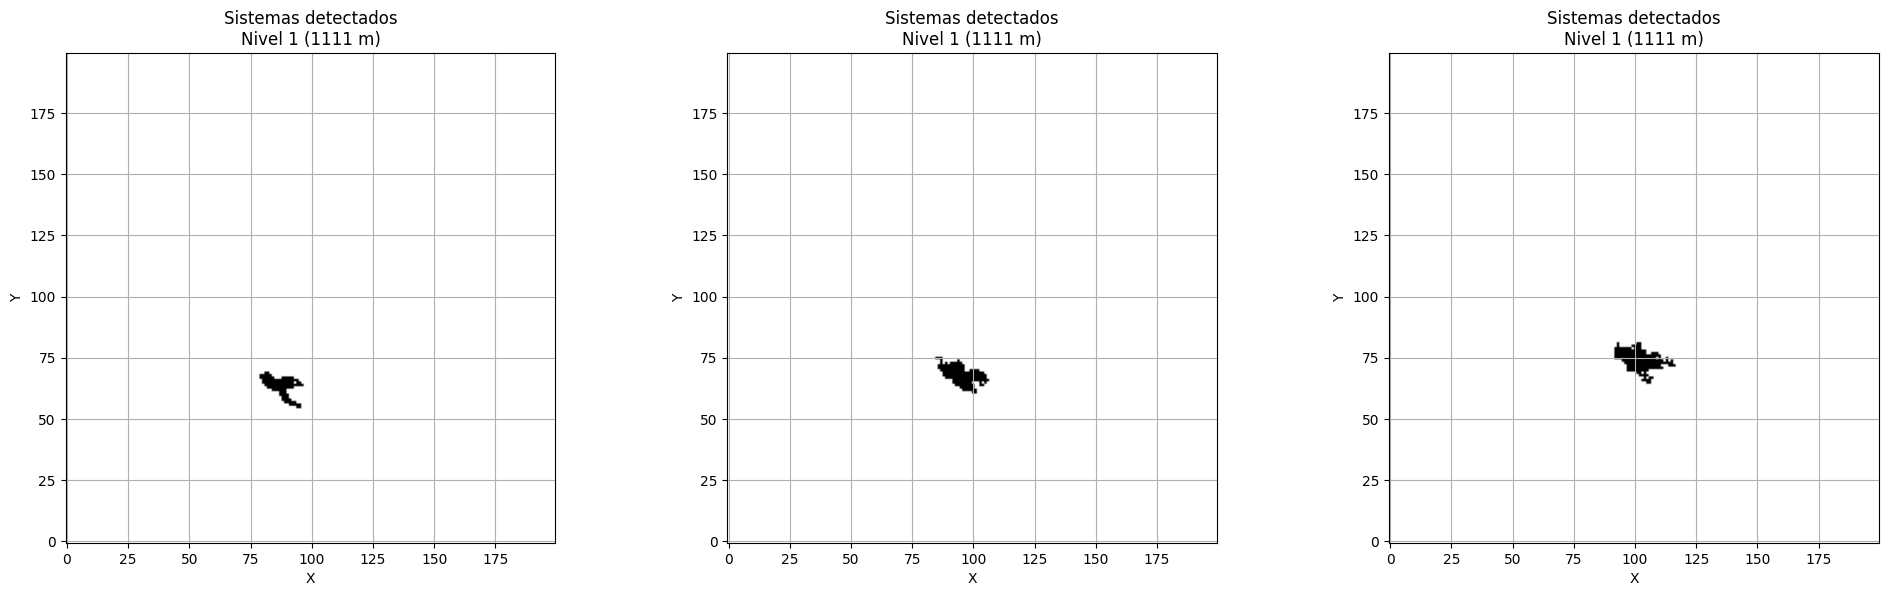

In [36]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
grids = [grid_inicial, grid_current_1, grid_current_2]

for i, grid in enumerate(grids):
    systems, mask = detectar_sistemas_convectivos_visual(grid, nivel=2, umbral_dbz=35,
                                                   min_area_km2=100, extent_km=200,
                                                   plot=False, return_mask=True)

    axs[i].imshow(mask, cmap=ListedColormap(['white', 'black']), origin='lower')
    axs[i].set_title(f"Sistemas detectados\nNivel 1 ({grid.z['data'][1]:.0f} m)")
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

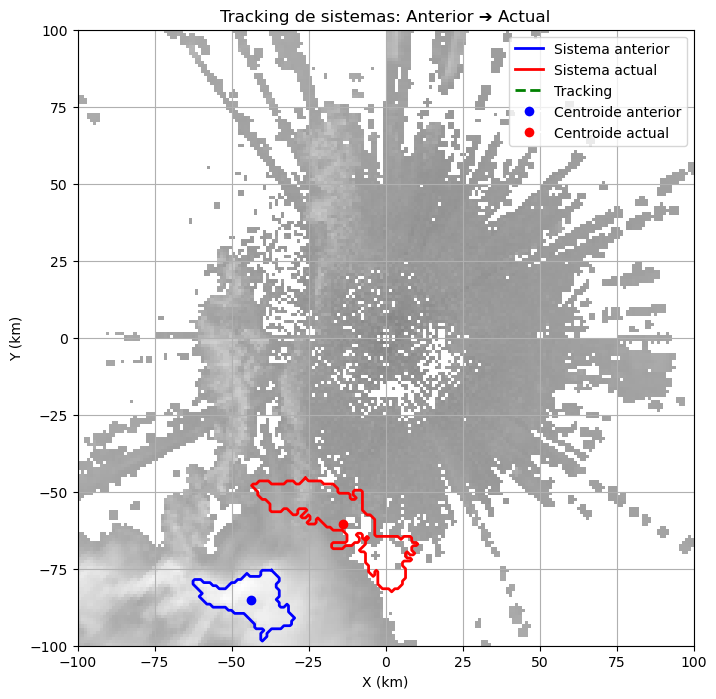

In [13]:
from shapely.geometry import Point
import numpy as np
from matplotlib.lines import Line2D

################################################################################################
# ESTA FUNCIóN MATCHEA O ASOCIA SISTEMAS EN DIFERENTES TIEMPOS SEGúN DISTANCIAS ENTRE CENTROIDES
# SOLO ADMITE MATCHEOS INDIVIDUALES
################################################################################################
def tracking_sistemas_por_dist_centroides(systems_old, systems_new, max_distance_km=20):
    matches = []
    for old in systems_old:
        old_centroid = np.array([old['centroid'].x, old['centroid'].y])

        best_match = None
        best_distance = np.inf

        for new in systems_new:
            new_centroid = np.array([new['centroid'].x, new['centroid'].y])
            distance = np.linalg.norm(old_centroid - new_centroid)

            if distance < best_distance:
                best_distance = distance
                best_match = new

        if best_match is not None and best_distance <= max_distance_km:
            matches.append({
                'old_id': old['id'],
                'new_id': best_match['id'],
                'distance_km': best_distance
            })
    return matches

################################################################################################
######## USO ###################################################################################
matches = tracking_sistemas_por_dist_centroides(systems_inicial, systems_current_1, max_distance_km=20)
######## COMPROBAMOS SI MATCEHARON SISTEMAS ENTRE 2 TIEMPOS ####################################
for match in matches:
    print(f"Sistema anterior {match['old_id']} ➔ sistema actual {match['new_id']} (distancia: {match['distance_km']:.2f} km)")
################################################################################################
# AHORA GRAFICAMOS ESO
################################################################################
plt.figure(figsize=(8,8))
# Fondo
plt.imshow(grid_inicial.fields['DBZH']['data'][1, :, :], cmap='gray', origin='lower', alpha=0.5, extent=[-100, 100, -100, 100])
################################################################################
# Sistemas anteriores (azul)
for system in systems_inicial:
    x, y = system['geometry'].exterior.xy
    plt.plot(x, y, color='blue', linewidth=2)
    plt.plot(system['centroid'].x, system['centroid'].y, 'bo')
################################################################################
# Sistemas actuales (rojo)
for system in systems_current_1:
    x, y = system['geometry'].exterior.xy
    plt.plot(x, y, color='red', linewidth=2)
    plt.plot(system['centroid'].x, system['centroid'].y, 'ro')
################################################################################
# Líneas de tracking (verde)
for match in matches:
    old = next(s for s in systems_inicial if s['id'] == match['old_id'])
    new = next(s for s in systems_current_1 if s['id'] == match['new_id'])

    plt.plot(
        [old['centroid'].x, new['centroid'].x],
        [old['centroid'].y, new['centroid'].y],
        color='green', linewidth=1.5, linestyle='--'
    )
################################################################################
# Leyenda
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Sistema anterior'),
    Line2D([0], [0], color='red', lw=2,  label='Sistema actual'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Tracking'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Centroide anterior'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Centroide actual')
]
################################################################################
plt.legend(handles=legend_elements, loc='best')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Tracking de sistemas: Anterior ➔ Actual')
plt.grid(True)
plt.show()
################################################################################

No hay emparejamientos posibles entre estos dos tiempos.


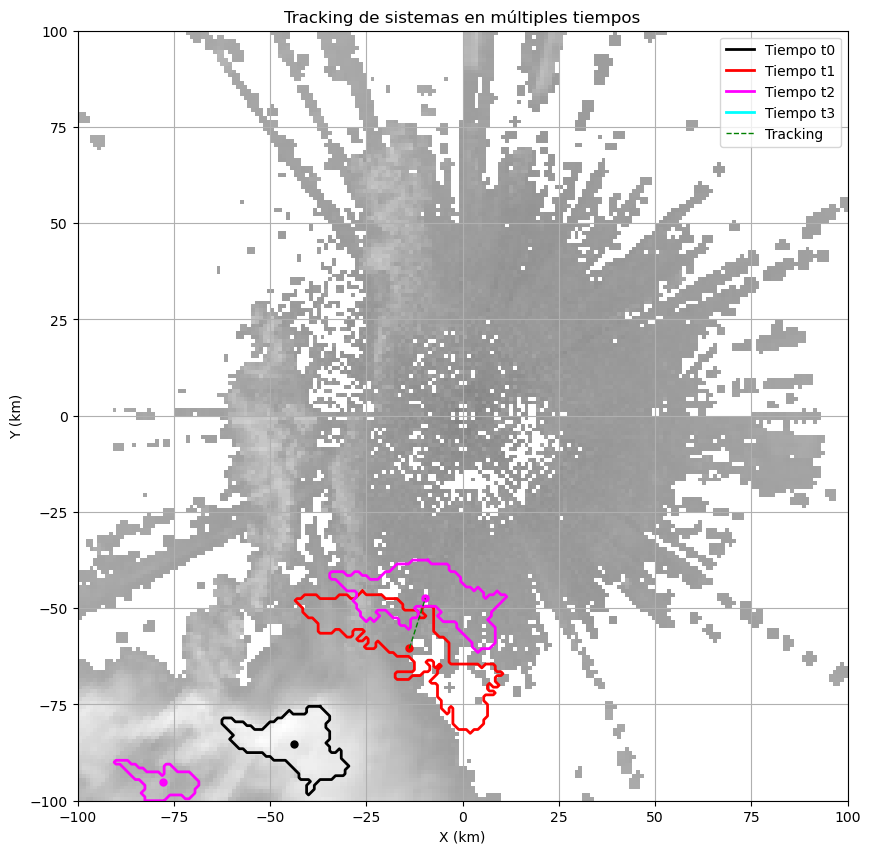

In [14]:
## En esta celda se realiza en tracking entre múltiples datos de radar.
## Se definen en la lista lista_sistemas_por_tiempo.
## El tracking se realiza sólo por distancias entre centroides y es única entre ellos.
## Existe el problema en que puede no seguir la línea de movimiento de los SC.
## En la próxima celda se implementa una posible mejora.

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

##############################################################################################################
lista_sistemas_por_tiempo = [systems_inicial, systems_current_1, systems_current_2]
##############################################################################################################
def tracking_asignacion_optima(systems_old, systems_new, max_distance_km=20):
    n_old = len(systems_old)
    n_new = len(systems_new)
    # Crea matriz de distancias
    cost_matrix = np.full((n_old, n_new), np.inf)
    for i, old in enumerate(systems_old):
        old_centroid = np.array([old['centroid'].x, old['centroid'].y])
        for j, new in enumerate(systems_new):
            new_centroid = np.array([new['centroid'].x, new['centroid'].y])
            distance = np.linalg.norm(old_centroid - new_centroid)
            if distance <= max_distance_km:
                cost_matrix[i, j] = distance
    # Filtrar filas y columnas con al menos un valor válido
    filas_validas = ~np.all(np.isinf(cost_matrix), axis=1)
    columnas_validas = ~np.all(np.isinf(cost_matrix), axis=0)
    if not np.any(filas_validas) or not np.any(columnas_validas):
        print("No hay emparejamientos posibles entre estos dos tiempos.")
        return []
    submatrix = cost_matrix[np.ix_(filas_validas, columnas_validas)]
    # Resolver el subproblema reducido
    row_sub, col_sub = linear_sum_assignment(submatrix)
    # Mapear a índices originales
    row_ind = np.where(filas_validas)[0][row_sub]
    col_ind = np.where(columnas_validas)[0][col_sub]
    # Armar matches si la distancia no es inf
    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost_matrix[i, j] != np.inf:
            matches.append({
                'old_id': systems_old[i]['id'],
                'new_id': systems_new[j]['id'],
                'distance_km': cost_matrix[i, j]
            })
    return matches

##############################################################################################################
def tracking_en_serie(all_systems, max_distance_km=20):
    all_matches = []
    for i in range(len(all_systems) - 1):
        matches = tracking_asignacion_optima(all_systems[i], all_systems[i+1], max_distance_km)
        all_matches.append(matches)
    return all_matches
matches_por_paso = tracking_en_serie(lista_sistemas_por_tiempo, max_distance_km=30)

##############################################################################################################
def plot_tracking(all_systems, matches_por_paso, extent=None):

    colors = ['black', 'red', 'magenta', 'cyan']
    plt.figure(figsize=(10,10))
    # Fondo si lo hay
    if extent is not None:
        plt.imshow(
            extent['background'],  # por ejemplo reflectividad
            cmap='gray',
            origin='lower',
            extent=extent['extent'],
            alpha=0.5
        )

    # Plotear sistemas y centroides
    for t_index, systems in enumerate(all_systems):
        for system in systems:
            x, y = system['geometry'].exterior.xy
            plt.plot(x, y, color=colors[t_index], linewidth=2)
            plt.plot(system['centroid'].x, system['centroid'].y, 'o', color=colors[t_index], markersize=5)

    # Tracking entre tiempos consecutivos
    for t_index, matches in enumerate(matches_por_paso):
        systems_old = all_systems[t_index]
        systems_new = all_systems[t_index + 1]

        for match in matches:
            old = next(s for s in systems_old if s['id'] == match['old_id'])
            new = next(s for s in systems_new if s['id'] == match['new_id'])

            plt.plot(
                [old['centroid'].x, new['centroid'].x],
                [old['centroid'].y, new['centroid'].y],
                color='green', linestyle='--', linewidth=1
            )

    # Leyenda
    legend_elements = []
    for i, color in enumerate(colors):
        legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'Tiempo t{i}'))
    legend_elements.append(Line2D([0], [0], color='green', linestyle='--', lw=1, label='Tracking'))

    plt.legend(handles=legend_elements, loc='best')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title('Tracking de sistemas en múltiples tiempos')
    plt.grid(True)
    plt.show()
##############################################################################################################
plot_tracking(lista_sistemas_por_tiempo, matches_por_paso, extent={
    'background': grid_inicial.fields['DBZH']['data'][1, :, :],
    'extent': [-100, 100, -100, 100]
})
##############################################################################################################

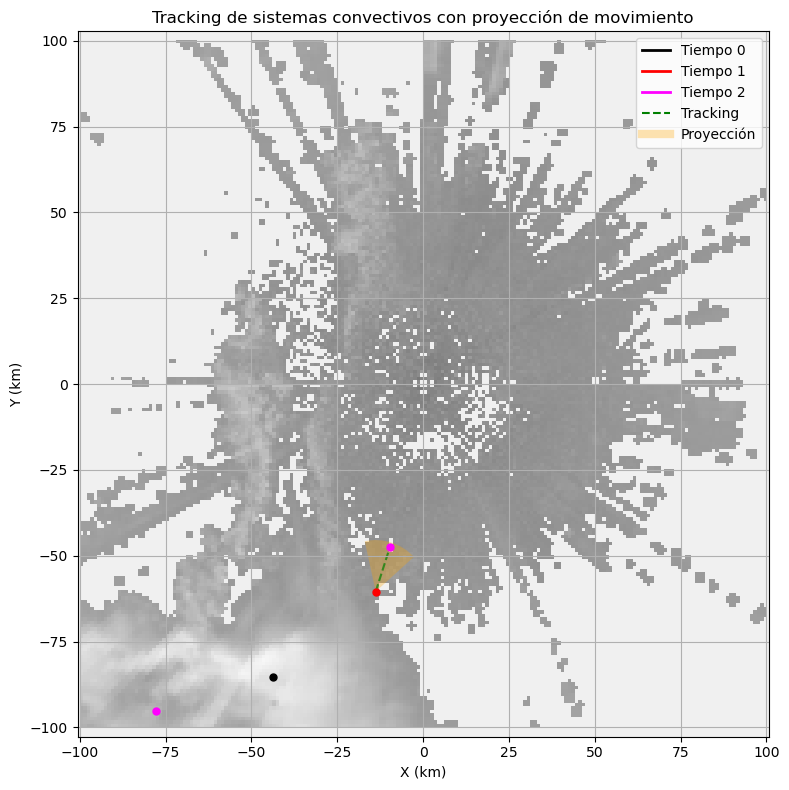

In [15]:
### Ahora esto funciona haciendo el tracking en la misma línea que se mueven los sistemas.

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Wedge

"""
# tracking_multipasos(...): Realiza el tracking entre pares consecutivos de tiempos.
# Qué hace?
# Recorre todos los tiempos consecutivos: t y t+1.
# Para cada sistema viejo (s_old) busca candidatos nuevos (s_new) cuya distancia sea ≤ max_distance_km.
# Si hay más de un candidato válido, elige el que tiene mayor área.


# Filtrar_matches_unicos(...): Elimina duplicados para que cada sistema nuevo esté emparejado con un solo sistema anterior.
# Qué hace?
# Agrupa los matches por (tiempo_new, new_id).
# De cada grupo, conserva el match con menor distancia (dist).
#  Esto garantiza una única asociación hacia atrás para cada sistema nuevo.
"""

lista_sistemas_por_tiempo = [systems_inicial, systems_current_1, systems_current_2]

####################################################################################
# TRACKING MULTIPASOS PERMITIENDO MULTIPLES MATCHES
def tracking_multipasos(lista_sistemas_por_tiempo, max_distance_km=25):
    matches = []
    for t in range(len(lista_sistemas_por_tiempo) - 1):
        systems_old = lista_sistemas_por_tiempo[t]
        systems_new = lista_sistemas_por_tiempo[t + 1]

        for s_old in systems_old:
            candidatos = []
            for s_new in systems_new:
                dist = s_old['centroid'].distance(s_new['centroid'])
                if dist <= max_distance_km:
                    candidatos.append((s_new, dist))
            if candidatos:
                # Elegir el candidato con mayor área
                s_mejor = max(candidatos, key=lambda x: x[0]['geometry'].area)[0]
                matches.append({
                    'tiempo_old': t,
                    'tiempo_new': t + 1,
                    'old_id': s_old['id'],
                    'new_id': s_mejor['id'],
                    'dist': s_old['centroid'].distance(s_mejor['centroid'])
                })
    return matches
####################################################################################
def filtrar_matches_unicos(matches):
    # Diccionario para agrupar por sistema nuevo
    nuevos = defaultdict(list)
    for m in matches:
        clave = (m['tiempo_new'], m['new_id'])
        nuevos[clave].append(m)
    # Para cada sistema nuevo se queda solo con el match más corto
    matches_filtrados = []
    for lista in nuevos.values():
        mejor = min(lista, key=lambda m: m['dist'])
        matches_filtrados.append(mejor)
    return matches_filtrados
####################################################################################
# GRAFICAR EL TRACKING CON CONOS DE DIRECCIóN
def graficar_tracking(lista_sistemas_por_tiempo, matches, grid=None):
    colores = ['black', 'red', 'magenta', 'cyan', 'orange', 'green', 'blue', 'purple']
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_facecolor('#f0f0f0')
    # Fondo reflectividad
    if grid is not None:
        plt.imshow(
            grid.fields['DBZH']['data'][1, :, :],
            cmap='gray', origin='lower', alpha=0.5,
            extent=[-100, 100, -100, 100]
        )

    all_x, all_y = [], []
    # Plotear centroides
    for t, systems in enumerate(lista_sistemas_por_tiempo):
        color = colores[t % len(colores)]
        for system in systems:
            try:
                x, y = system['geometry'].exterior.xy
                #plt.plot(x, y, color=color, linewidth=1.2, alpha=0.7, zorder=2)
                plt.plot(system['centroid'].x, system['centroid'].y, 'o', color=color, markersize=5, zorder=3)
                all_x.append(system['centroid'].x)
                all_y.append(system['centroid'].y)
            except:
                pass
    # Líneas de tracking
    for match in matches:
        try:
            t_old = match['tiempo_old']
            t_new = match['tiempo_new']
            s_old = next(s for s in lista_sistemas_por_tiempo[t_old] if s['id'] == match['old_id'])
            s_new = next(s for s in lista_sistemas_por_tiempo[t_new] if s['id'] == match['new_id'])

            plt.plot(
                [s_old['centroid'].x, s_new['centroid'].x],
                [s_old['centroid'].y, s_new['centroid'].y],
                color='green', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1
            )
        except:
            pass
    # CONOS DE DIRECCIÓN
    # para probar como graficar conos
    apertura = 60
    angulo_max_desvio = 45
    radio_cono = 15
    matches_por_origen = defaultdict(list)
    for m in matches:
        matches_por_origen[(m['tiempo_old'], m['old_id'])].append(m)

    for (t_old, old_id), lista_matches in matches_por_origen.items():
        if t_old >= len(lista_sistemas_por_tiempo) - 1:
            continue
        try:
            s_old = next(s for s in lista_sistemas_por_tiempo[t_old] if s['id'] == old_id)
            x0, y0 = s_old['centroid'].x, s_old['centroid'].y

            vectores = []
            destinos_validos = []

            for m in lista_matches:
                s_new = next(s for s in lista_sistemas_por_tiempo[m['tiempo_new']] if s['id'] == m['new_id'])
                dx = s_new['centroid'].x - x0
                dy = s_new['centroid'].y - y0
                vectores.append((np.array([dx, dy]), s_new))

            if not vectores:
                continue

            v_ref, _ = min(vectores, key=lambda v: np.linalg.norm(v[0]))
            norm_ref = np.linalg.norm(v_ref)
            if norm_ref == 0:
                continue
            v_ref_unit = v_ref / norm_ref

            for v, s_new in vectores:
                norm_v = np.linalg.norm(v)
                if norm_v == 0:
                    continue
                v_unit = v / norm_v
                cos_theta = np.clip(np.dot(v_unit, v_ref_unit), -1.0, 1.0)
                angulo = np.degrees(np.arccos(cos_theta))
                if angulo <= angulo_max_desvio:
                    destinos_validos.append(v)

            if not destinos_validos:
                continue

            v_resultante = np.mean(destinos_validos, axis=0)
            angulo_resultante = np.degrees(np.arctan2(v_resultante[1], v_resultante[0]))

            cono = Wedge(center=(x0, y0),
                         r=radio_cono,
                         theta1=angulo_resultante - apertura / 2,
                         theta2=angulo_resultante + apertura / 2,
                         facecolor='orange',
                         alpha=0.3,
                         zorder=0)
            ax.add_patch(cono)
        except:
            continue
    # Leyenda
    legend_elements = [Line2D([0], [0], color=colores[t % len(colores)], lw=2, label=f'Tiempo {t}')
                       for t in range(len(lista_sistemas_por_tiempo))]
    legend_elements.append(Line2D([0], [0], color='green', lw=1.5, linestyle='--', label='Tracking'))
    legend_elements.append(Line2D([0], [0], color='orange', lw=6, alpha=0.3, label='Proyección'))
    plt.legend(handles=legend_elements, loc='best')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title('Tracking de sistemas convectivos con proyección de movimiento')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

####################################################################################
multi_matches = tracking_multipasos(lista_sistemas_por_tiempo, max_distance_km=25)
multi_matches_filtrados = filtrar_matches_unicos(multi_matches)
graficar_tracking(lista_sistemas_por_tiempo, multi_matches_filtrados, grid=grid_inicial)
####################################################################################

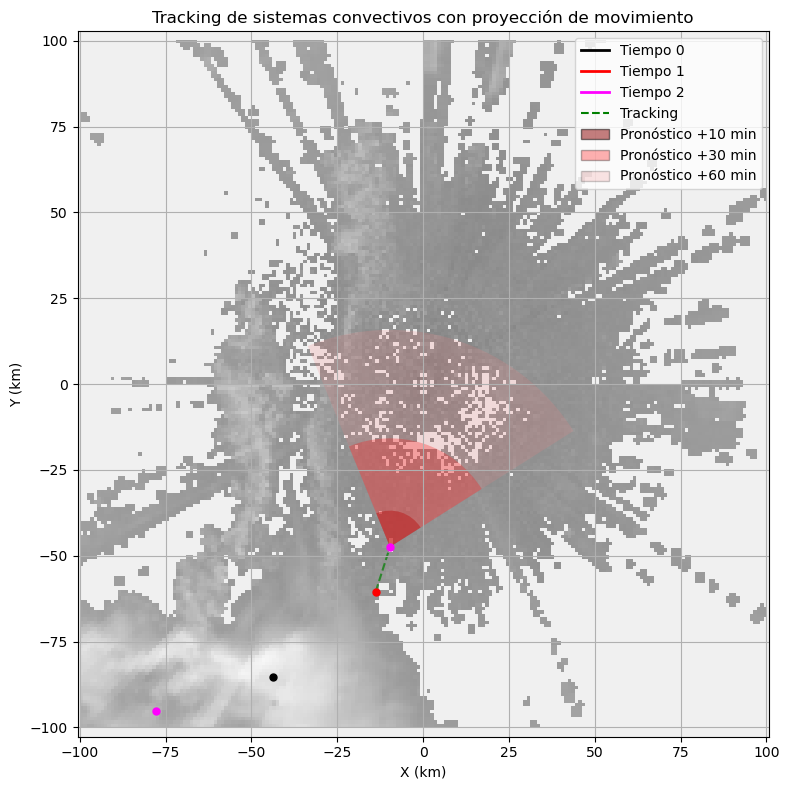

In [16]:
from matplotlib.patches import Wedge
from matplotlib.lines import Line2D
import numpy as np
from matplotlib.patches import Patch

####################################################################################
def graficar_tracking(lista_sistemas_por_tiempo, matches, grid=None, forecast_cones_config=None):
    colores = ['black', 'red', 'magenta', 'cyan', 'orange', 'green', 'blue', 'purple']
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_facecolor('#f0f0f0')

    if grid is not None:
        plt.imshow(
            grid.fields['DBZH']['data'][1, :, :],
            cmap='gray', origin='lower', alpha=0.5,
            extent=[-100, 100, -100, 100]
        )

    all_x, all_y = [], []

    for t, systems in enumerate(lista_sistemas_por_tiempo):
        color = colores[t % len(colores)]
        for system in systems:
            # try:
            #     plt.plot(system['centroid'].x, system['centroid'].y, 'o', color=color, markersize=5, zorder=3)
            #     all_x.append(system['centroid'].x)
            #     all_y.append(system['centroid'].y)
            # except:
            #     pass

        # Dibujar la figura (contorno del SC)
            if 'geometry' in system:
                try:
                    x, y = system['geometry'].exterior.xy
                    #plt.plot(x, y, color=color, linewidth=1.2, alpha=0.7, zorder=2)
                except:
                    pass

            # Dibujar el centroide
            plt.plot(system['centroid'].x, system['centroid'].y, 'o', color=color, markersize=5, zorder=3)


    # Líneas de tracking
    for match in matches:
        try:
            t_old = match['tiempo_old']
            t_new = match['tiempo_new']
            s_old = next(s for s in lista_sistemas_por_tiempo[t_old] if s['id'] == match['old_id'])
            s_new = next(s for s in lista_sistemas_por_tiempo[t_new] if s['id'] == match['new_id'])

            plt.plot(
                [s_old['centroid'].x, s_new['centroid'].x],
                [s_old['centroid'].y, s_new['centroid'].y],
                color='green', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1
            )
        except:
            pass

    # CONOS DE PRONÓSTICO MULTITEMPORAL
    if forecast_cones_config:
        delta_t = forecast_cones_config['delta_t']
        forecast_minutes = forecast_cones_config['forecast_minutes']
        colores_forecast = forecast_cones_config['colores']

        for match in matches:
            try:
                s_old = next(s for s in lista_sistemas_por_tiempo[match['tiempo_old']] if s['id'] == match['old_id'])
                s_new = next(s for s in lista_sistemas_por_tiempo[match['tiempo_new']] if s['id'] == match['new_id'])

                dx = (s_new['centroid'].x - s_old['centroid'].x) / delta_t
                dy = (s_new['centroid'].y - s_old['centroid'].y) / delta_t
                angulo = np.degrees(np.arctan2(dy, dx))

                centro = (s_new['centroid'].x, s_new['centroid'].y)
                alphas = forecast_cones_config.get('alphas', [0.25] * len(forecast_minutes))  # Valor por defecto si no está

                for i, t_forecast in enumerate(forecast_minutes):
                    shift_x = dx * t_forecast
                    shift_y = dy * t_forecast
                    radio = np.sqrt(shift_x**2 + shift_y**2)
                    ang_apertura = 40 #### acá se define el ángulo de apertura del cono
                    cono = Wedge(
                        center=centro,
                        r=radio,
                        theta1=angulo - ang_apertura,
                        theta2=angulo + ang_apertura,
                        facecolor=colores_forecast[i],
                        alpha=alphas[i],
                        zorder=0
                    )
                    ax.add_patch(cono)
            except:
                continue

    # Límites del gráfico
    if all_x and all_y:
        plt.xlim(min(all_x) - 5, max(all_x) + 5)
        plt.ylim(min(all_y) - 5, max(all_y) + 5)

    # Leyenda
    legend_elements = [Line2D([0], [0], color=colores[t % len(colores)], lw=2, label=f'Tiempo {t}')
                       for t in range(len(lista_sistemas_por_tiempo))]
    legend_elements.append(Line2D([0], [0], color='green', lw=1.5, linestyle='--', label='Tracking'))
    #legend_elements.append(Line2D([0], [0], color='orange', lw=6, alpha=0.3, label='Proyección'))
    #legend_elements.append(Line2D([0], [0], marker='x', linestyle='None', color='gray', label='Centroide pronosticado'))

    if forecast_cones_config:
      forecast_labels = [f'Pronóstico +{m} min' for m in forecast_cones_config['forecast_minutes']]
      forecast_colors = forecast_cones_config['colores']
      forecast_alphas = forecast_cones_config.get('alphas', [0.25] * len(forecast_colors))

      for label, color, alpha in zip(forecast_labels, forecast_colors, forecast_alphas):
          legend_elements.append(Patch(facecolor=color, edgecolor='black', alpha=alpha, label=label))

    plt.legend(handles=legend_elements, loc='best')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title('Tracking de sistemas convectivos con proyección de movimiento')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

####################################################################################
forecast_cones_config = {
    'delta_t': 13,
    'forecast_minutes': [10, 30, 60],
    'colores': ['darkred', 'red', 'lightcoral'],
    'alphas': [0.5, 0.3, 0.2]
}
####################################################################################

multi_matches = tracking_multipasos(lista_sistemas_por_tiempo, max_distance_km=25)
multi_matches_filtrados = filtrar_matches_unicos(multi_matches)
graficar_tracking(
    lista_sistemas_por_tiempo,
    multi_matches_filtrados,
    grid = grid_inicial,
    forecast_cones_config=forecast_cones_config
)